## Making simple projections, sinograms and reconstructions from a virtual sample

In [1]:
#installs
!pip install algotom
#imports
import numpy as np
import skimage as sk
import imageio as io
import matplotlib.pyplot as plt
import algotom.rec.reconstruction as rec
from tqdm import tqdm
from skimage.transform import rotate
from skimage.color import rgb2gray

### (1) Make Volume Image

C:\Users\Matthew\AppData\Local\Temp\ipykernel_20876\2682176042.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = io.imread('C:/Users/Matthew/Desktop/shapes.tiff')


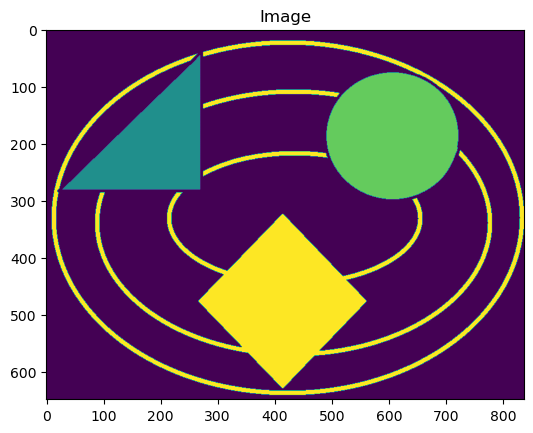

In [2]:
#read shapes.tiff
image = io.imread('C:/Users/Matthew/Desktop/shapes.tiff')
image = image[:,:,1]
#plot image
plt.imshow(image, cmap = 'viridis')
plt.title('Image')
plt.show()

(1237, 1237)


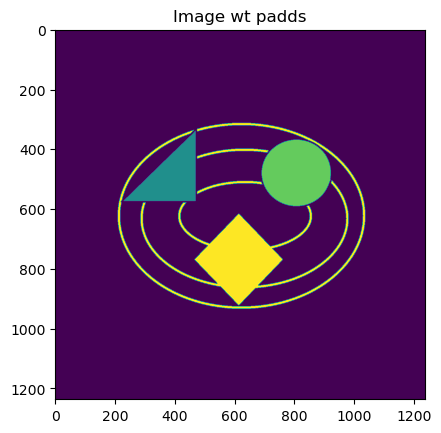

In [3]:
#pad so that image stays within bounds when rotated and has equal dimensions
image_pad = np.pad(image, ((294,295),(200,200)))
print(image_pad.shape)
#plot
plt.imshow(image_pad, cmap = 'viridis')
plt.title('Image wt padds')
plt.show()

In [4]:
#turn image into a volume; in this case by stacking the image on top of itself to make a kind of prism volume
og_vol = []
for i in range(10):
    og_vol.append(image_pad)
og_vol = np.array(og_vol)
og_vol = np.pad(og_vol, ((2,2),(0,0),(0,0)))

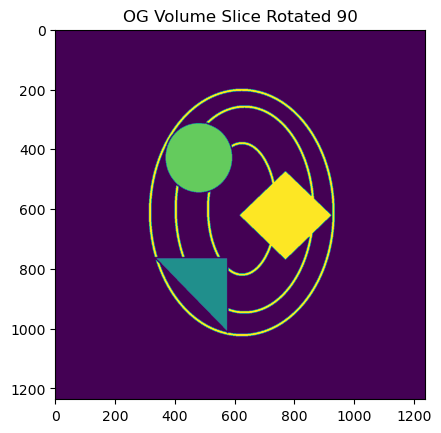

In [5]:
#plot at 90 degs to check volume of interest stays in 'field of view'
rot_vol = []
for i in og_vol:
    i = rotate(i, 90)
    rot_vol.append(i)
rot_vol = np.array(rot_vol)
plt.imshow(rot_vol[7], cmap = 'viridis')
plt.title('OG Volume Slice Rotated 90')
plt.show()

### (2) Simulate Projections 

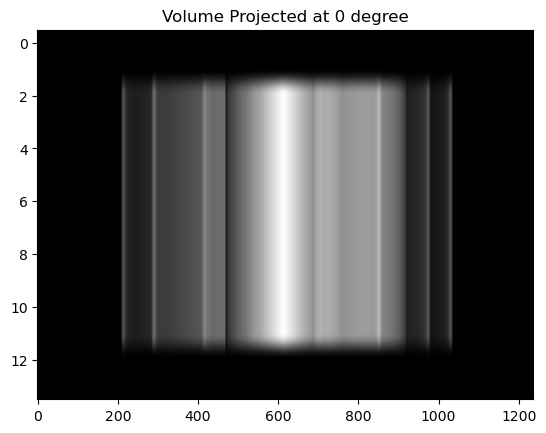

In [6]:
#now we simulate x-ray projections being captured by summing values along the x-axis rows of the 3d array at each angle
proj = []
for im in og_vol:
    line = np.sum(im, axis=0)
    proj.append(line)
    
plt.imshow(proj, cmap = 'gray', aspect = 'auto')
plt.title('Volume Projected at 0 degree')
plt.show()

In [7]:
# now we repeat this for our range of angles to get projections from multiple angles
# ***WARNING*** this slow af
projs = []
for angle in tqdm(range(0,360)):
    proj = []
    rot_vol = []
    for i in og_vol:
        i = rotate(i, angle)
        rot_vol.append(i)
    for im in rot_vol:
        line = np.sum(im, axis=0)
        proj.append(line)
    projs.append(np.array(proj))

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [11:35<00:00,  1.93s/it]


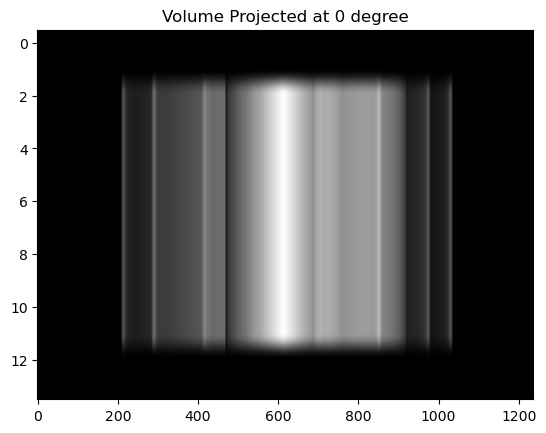

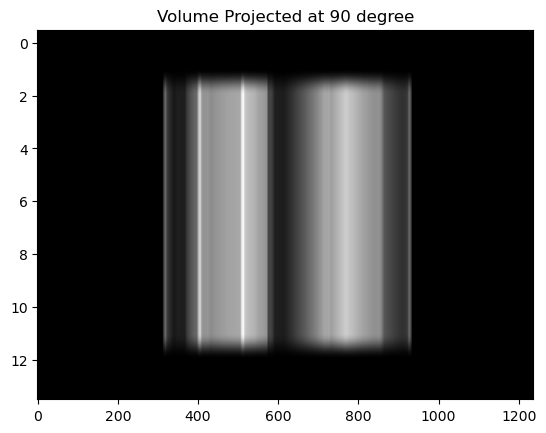

In [8]:
#plot projections at 0 and 90 degrees
plt.imshow(projs[0], cmap = 'gray', aspect = 'auto')
plt.title('Volume Projected at 0 degree')
plt.show()
plt.imshow(projs[90], cmap = 'gray', aspect = 'auto')
plt.title('Volume Projected at 90 degree')
plt.show()

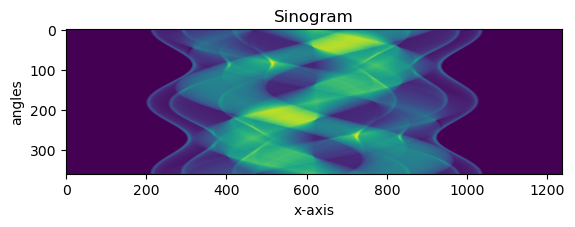

In [9]:
# now that we have 'projections' we can plot a sinogram by reslicing along the other dimension
projs = np.array(projs)
plt.imshow(projs[:,7,:], cmap = 'viridis')
plt.title('Sinogram')
plt.ylabel('angles')
plt.xlabel('x-axis')
plt.show()

### (3) Reconstruct the original volume using back projection 

In [10]:
#make list of angles in radians
angle = 0 
angles = []
for j in range(360):
    angles.append(angle)
    angle += 1
angles = np.array(angles)
angles = angles * (np.pi/180)

In [11]:
centre = (projs.shape[2])/2
projs_fbp = projs.astype(np.float32)
recon_fbp = rec.fbp_reconstruction(projs_fbp, centre, angles, ratio=0.95, ramp_win=None, filter_name='hamming', apply_log=False, gpu=False, ncore=None)

In [12]:
fbp = np.fliplr(rotate(recon_fbp, 180)) #rotate and flip so same as og image
og_normed = og_vol / np.amax(og_vol) #normalize
diff = fbp[:,7,:] - og_normed[7,:,:] #calculate difference map of original and reconstructed data

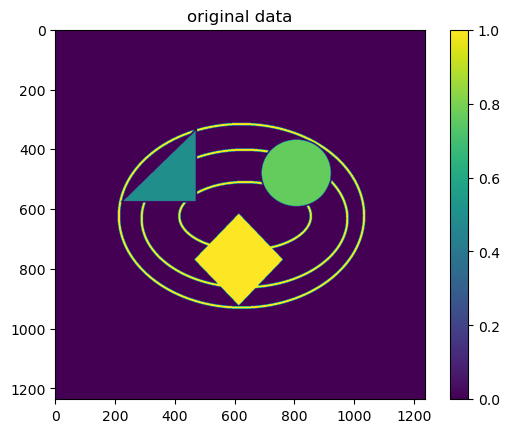

In [13]:
plt.imshow(og_normed[7])
plt.title('original data')
plt.colorbar()
plt.show()

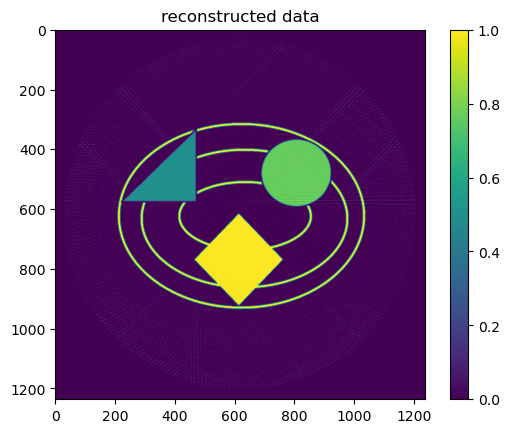

In [15]:
plt.imshow(fbp[:,7,:], vmin = 0, vmax = 1)
plt.title('reconstructed data')
plt.colorbar()
plt.show()

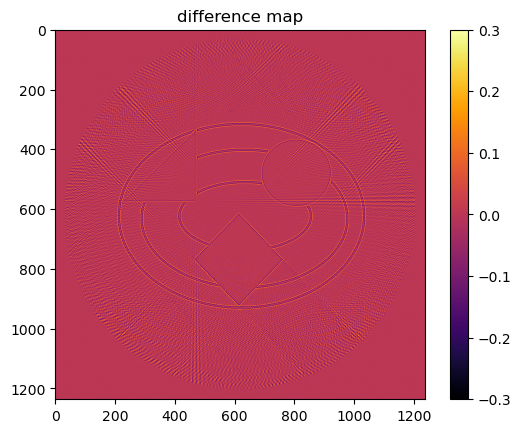

In [18]:
plt.imshow(diff, cmap = 'inferno', vmin = -0.3, vmax = 0.3)
plt.title('difference map')
plt.colorbar()
plt.show()

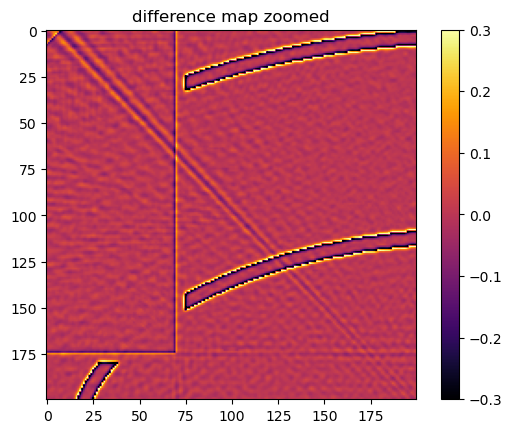

In [20]:
plt.imshow(diff[400:600, 400:600], cmap = 'inferno', vmin = -0.3, vmax = 0.3)
plt.title('difference map zoomed')
plt.colorbar()
plt.show()

In [ ]:
# notice how sharp edges are often a region for error in reconstructions 